In [15]:
pip install mediapy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import time
import mujoco
import mujoco.viewer
# from mujoco import mjx
import mediapy as media
import matplotlib.pyplot as plt
from IPython.display import display, Video

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [ ]:
model = mujoco.MjModel.from_xml_path("../models/scene.xml")
data = mujoco.MjData(model)
duration = 10  # (seconds)
framerate = 30  # (Hz)
width, height = 720, 480  # Desired resolution

In [ ]:
# Apply random inputs to the actuators
mujoco.mj_resetData(model, data)
# data.ctrl[:] = np.random.uniform(-1, 1, data.ctrl.shape)
data.ctrl[:] = np.array([0.0, 0.0])

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
scene_option.geomgroup[:] = 1  # Enable visibility for all groups

count = 0

# Simulate and display video.
frames = []
joint_angles = []
with mujoco.Renderer(model, width=width, height=height) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    joint_angles.append(data.sensordata.copy()) # Record joint angles
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)
    
    if data.time > 4:
      data.ctrl[:] = np.array([1, 1])


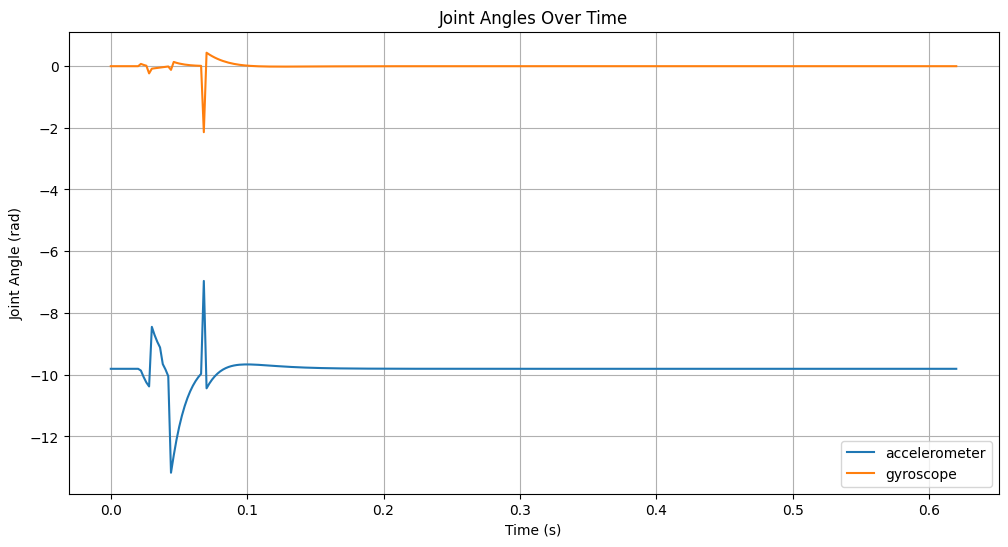

In [ ]:
# Plot joint angles with joint names in legend
joint_angles = np.array(joint_angles)[1990:2300, :]
time = np.linspace(0, joint_angles.shape[0] * 0.002, joint_angles.shape[0])

plt.figure(figsize=(12, 6))
sensor_names = [model.sensor(i).name for i in range(2)]
for i in range(2):
    plt.plot(time, joint_angles[:, i], label=sensor_names[i])
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angles Over Time')
plt.legend(sensor_names)
plt.grid(True)
plt.show()

Wheel 0 RMSE (qvel - cmd): 0.7799
Wheel 1 RMSE (qvel - cmd): 1.1550


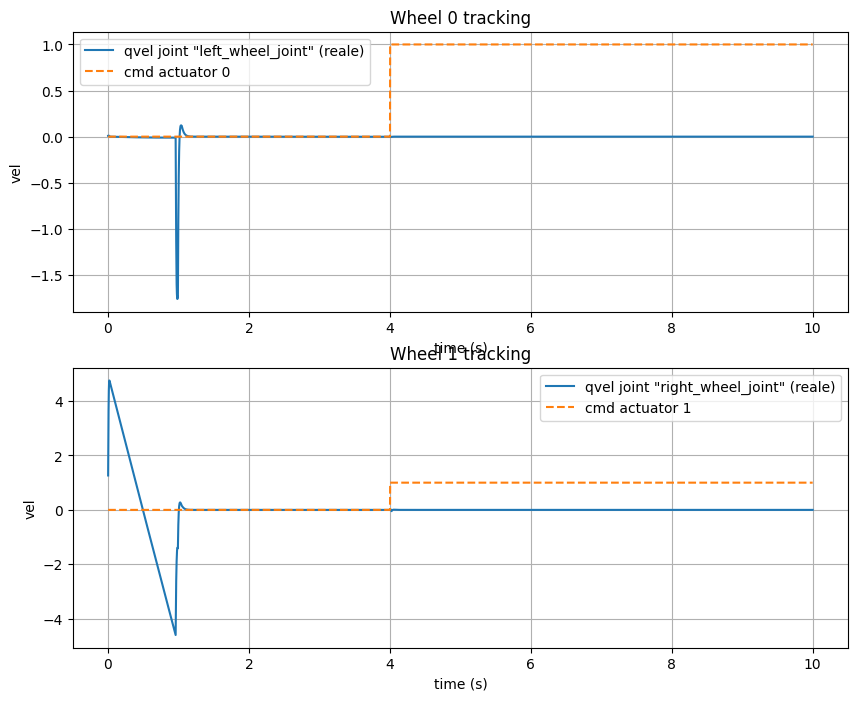

In [8]:
ctrl_history = []
qvel_history = []
time_history = []
frames = []
joint_angles = []
# Identify wheel joints automatically (nome contenente 'wheel')
joint_names = [model.joint(i).name for i in range(model.njnt)]
wheel_idxs = [i for i, n in enumerate(joint_names) if 'wheel' in n.lower()]
if len(wheel_idxs) == 0:
    # fallback: usa le prime 2 giunture se non trova "wheel"
    wheel_idxs = [0, 1]

# Reset sim
mujoco.mj_resetData(model, data)
data.ctrl[:] = np.array([0.0, 0.0])
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
scene_option.geomgroup[:] = 1  # Enable visibility for all groups
with mujoco.Renderer(model, width=width, height=height) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        ctrl_history.append(data.ctrl.copy())
        qvel_history.append(data.qvel.copy())
        time_history.append(data.time)
        # render frames if vuoi
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option)
            pixels = renderer.render()
            frames.append(pixels)
        if data.time > 4:
            data.ctrl[:] = np.array([1.0, 1.0])

# Convert to arrays
ctrl_arr = np.array(ctrl_history)            # shape (T, nctrl)
qvel_arr = np.array(qvel_history)            # shape (T, nq)
time_arr = np.array(time_history)

# Extract wheel angular velocities and commanded values for the actuators
# Nota: l'unità del comando (data.ctrl) può essere diversa dall'unità di qvel:
# potrebbe essere velocità desiderata, coppia, o torque-clip — verifica il modello MuJoCo.
wheel_qvel = qvel_arr[:, wheel_idxs]        # shape (T, n_wheels)
# Per i comandi, assumiamo i primi len(wheel_idxs) actuator corrispondono alle ruote
cmd_idxs = list(range(min(ctrl_arr.shape[1], len(wheel_idxs))))
wheel_cmd = ctrl_arr[:, cmd_idxs]

# Plot comando vs reale
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4*len(wheel_idxs)))
for i, w in enumerate(wheel_idxs):
    plt.subplot(len(wheel_idxs), 1, i+1)
    plt.plot(time_arr, wheel_qvel[:, i], label=f'qvel joint "{joint_names[w]}" (reale)')
    if wheel_cmd.shape[1] > i:
        plt.plot(time_arr, wheel_cmd[:, i], '--', label=f'cmd actuator {i}')
    plt.xlabel('time (s)')
    plt.ylabel('vel')
    plt.title(f'Wheel {i} tracking')
    plt.legend()
    plt.grid(True)

# Calcola RMSE (attenzione: scale possibili diverse)
for i in range(len(wheel_idxs)):
    if wheel_cmd.shape[1] > i:
        # se necessario, scalare wheel_cmd[:,i] per unità coerenti
        err = wheel_qvel[:, i] - wheel_cmd[:, i]
        rmse = np.sqrt(np.mean(err**2))
        print(f'Wheel {i} RMSE (qvel - cmd): {rmse:.4f}')

plt.show()

In [ ]:
import mujoco
import numpy as np

# Carica il modello
model = mujoco.MjModel.from_xml_path("../models/SBRobot_Snello.xml")
data = mujoco.MjData(model)

# Esegui la cinematica per aggiornare le posizioni globali
mujoco.mj_kinematics(model, data)

# 1. Trova l'ID dello Chassis e delle Ruote
chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "Chassis")
wheel_L_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "WheelL")

# 2. Calcola il Centro di Massa (CoM) della parte "Pendolo"
# MuJoCo calcola il CoM del subtree. Usiamo quello dello chassis.
# NOTA: mj_subtreeCom include tutti i figli. 
# Per precisione assoluta dovremmo sottrarre la massa delle ruote se considerate "a terra",
# ma dato che il loro CoM è sull'asse, includerle cambia solo la massa totale, non il momento rispetto all'asse.
com_total = data.subtree_com[chassis_id]

# 3. Trova la posizione dell'asse delle ruote (Pivot)
# Usiamo la posizione globale della ruota sinistra (o media tra le due)
pivot_pos = data.xpos[wheel_L_id] 

# 4. Calcola le distanze relative
dx = com_total[0] - pivot_pos[0] # Distanza orizzontale CoM - Perno
dz = com_total[2] - pivot_pos[2] # Altezza CoM rispetto al Perno

# 5. Calcola l'angolo (Pitch)
# Se dx è positivo (CoM avanti), dobbiamo inclinare indietro (angolo negativo)
angle_rad = -np.arctan2(dx, dz)

print(f"Posizione CoM (X, Z): {com_total[0]:.4f}, {com_total[2]:.4f}")
print(f"Posizione Perno (X, Z): {pivot_pos[0]:.4f}, {pivot_pos[2]:.4f}")
print(f"Delta X (Sbilanciamento): {dx*1000:.2f} mm")
print(f"---")
print(f"Angolo di Offset (Equilibrio): {angle_rad:.4f} radianti")

